# Planetary System

Using the solar system we live in as an example, we can create a planetary system with the Sun at the center and the planets orbiting around it. Because of this fact, we can assume the Sun's center to be the barycenter of the system.
 This means that the hamiltonian of the system can be split into the Keplarian and interactive part. $$H = H_{Keplarian} + H_{int}$$ $$H_{Keplarian} = \sum_{i=1}^{N} \frac{p_i^2}{2m_i} - \sum_{j=1}^{N} \frac{Gm_0m_j}{|r_j|}$$ $$H_{int} = \sum_{i=1}^{N} \sum_{j=1}^{N} \frac{Gm_im_j}{|r_i - r_j|}$$
 The Wisdom-Holman symplectic integrator is used to integrate the system. We will be using the rebound library to in order to use the whfast integrator

We will also use a hamiltonian neural network. A nomral neural network will use input values to predict the next values however the hamiltonian neural network will first get a hamiltonian and do many gradient steps on the hamiltonian to predict the next value. This makes it conserve the hamiltonian and thus conserve energy.

We will use two dimensions in this case, although it is extendable to three dimensions. It is easier to visualize in two dimensions.

In [1]:
import matplotlib.pyplot as plt
import torch, time, os, sys
import numpy as np
import scipy.integrate, scipy.ndimage
from nn_model import MLP
from hnn import hnn
from data import get_dataset, get_orbit, random_config, potential_energy, kinetic_energy, total_energy


def get_args():
    return {'nonlinearity': 'tanh', 'hidden_dim': 256, 'input_dim': 12, 'learning_rate': 1e-3, 'batch_size': 1000,
            'total_steps': 100000, 'print_every': 100, 'name': '3body', 'verbose': True, 'field_type': 'solenoidal',
            'seed': 0, 'save_dir': '/home/kevin/code/project/3body'}


class ObjectView(object):
    def __init__(self, d): self.__dict__ = d


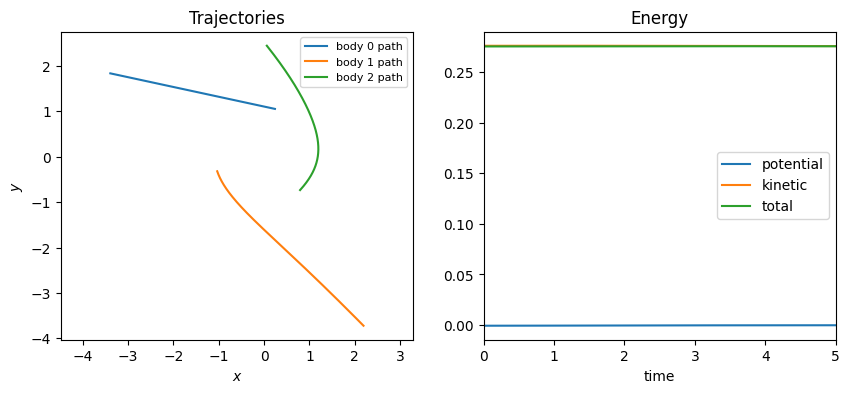

In [2]:
args = ObjectView(get_args())
np.random.seed(0)
state = random_config(0.2, 0.9, 1.2)
orbit, settings = get_orbit(state, t_points=1000, t_span=[0, 5], rtol=1e-9)
fig = plt.figure(figsize=[10, 4], dpi=100)
plt.subplot(1, 2, 1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))
plt.axis('equal')
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(fontsize=8)
plt.subplot(1, 2, 2)
plt.title('Energy');
plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])
plt.show()

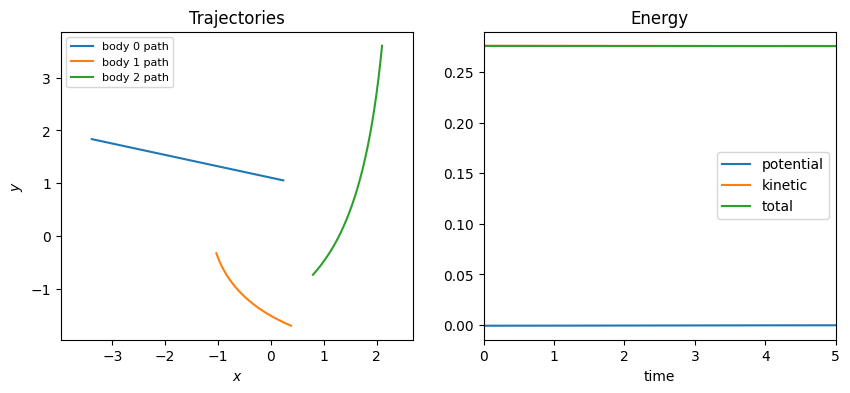

In [3]:
import rebound

sim = rebound.Simulation()
sim.add(m=state[0][0], x=state[0][1], y=state[0][2], vx=state[0][3], vy=state[0][4])
sim.add(m=state[1][0], x=state[1][1], y=state[1][2], vx=state[1][3], vy=state[1][4])
sim.add(m=state[2][0], x=state[2][1], y=state[2][2], vx=state[2][3], vy=state[2][4])
sim.integrator = "WHFast"
sim.dt = (settings['t_span'][1] - settings['t_span'][0]) / settings['t_points']

# 3x2xsteps
orbit = np.zeros((3, 5, settings['t_points']))
energy = np.zeros(settings['t_points'])
for i in range(settings['t_points']):
    sim.step()
    orbit[:, :, i] = np.array(
        [[state[0][0], sim.particles[0].x, sim.particles[0].y, sim.particles[0].vx, sim.particles[0].vy],
         [state[1][0], sim.particles[1].x, sim.particles[1].y, sim.particles[1].vx, sim.particles[1].vy],
         [state[2][0], sim.particles[2].x, sim.particles[2].y, sim.particles[2].vx, sim.particles[2].vy]])
    energy[i] = sim.energy()

fig = plt.figure(figsize=[10, 4], dpi=100)
plt.subplot(1, 2, 1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))
plt.axis('equal')
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(fontsize=8)
plt.subplot(1, 2, 2)
plt.title('Energy');
plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])
plt.show()


In [4]:
def load_model(args):
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = hnn(args.input_dim, differentiable_model=nn_model, field_type=args.field_type)
    label = 'hnn'
    path = '{}/{}_{}.pt'.format(args.save_dir, args.name, label)
    model.load_state_dict(torch.load(path))
    return model


hnn_model = load_model(args)


def model_update(t, state, model):
    state = state.reshape(-1, 5)

    deriv = np.zeros_like(state)
    np_x = state[:, 1:]  # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_deriv(x)
    deriv[:, 1:] = dx_hat.detach().data.numpy().reshape(4, 3).T
    return deriv.reshape(-1)


np.random.seed(0)
t_points = 2000
t_span = [0, 5]
state = random_config(0.2, 0.9, 1.2)

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

orbit = np.zeros((3, 5, t_points))
sim = rebound.Simulation()
sim.add(m=state[0][0], x=state[0][1], y=state[0][2], vx=state[0][3], vy=state[0][4])
sim.add(m=state[1][0], x=state[1][1], y=state[1][2], vx=state[1][3], vy=state[1][4])
sim.add(m=state[2][0], x=state[2][1], y=state[2][2], vx=state[2][3], vy=state[2][4])
sim.integrator = "WHFast"
sim.dt = (t_span[1] - t_span[0]) / t_points

for i in range(t_points):
    sim.step()
    orbit[:, :, i] = np.array(
        [[state[0][0], sim.particles[0].x, sim.particles[0].y, sim.particles[0].vx, sim.particles[0].vy],
         [state[1][0], sim.particles[1].x, sim.particles[1].y, sim.particles[1].vx, sim.particles[1].vy],
         [state[2][0], sim.particles[2].x, sim.particles[2].y, sim.particles[2].vx, sim.particles[2].vy]])

update_fn = lambda t, y0: model_update(t, y0, hnn_model)


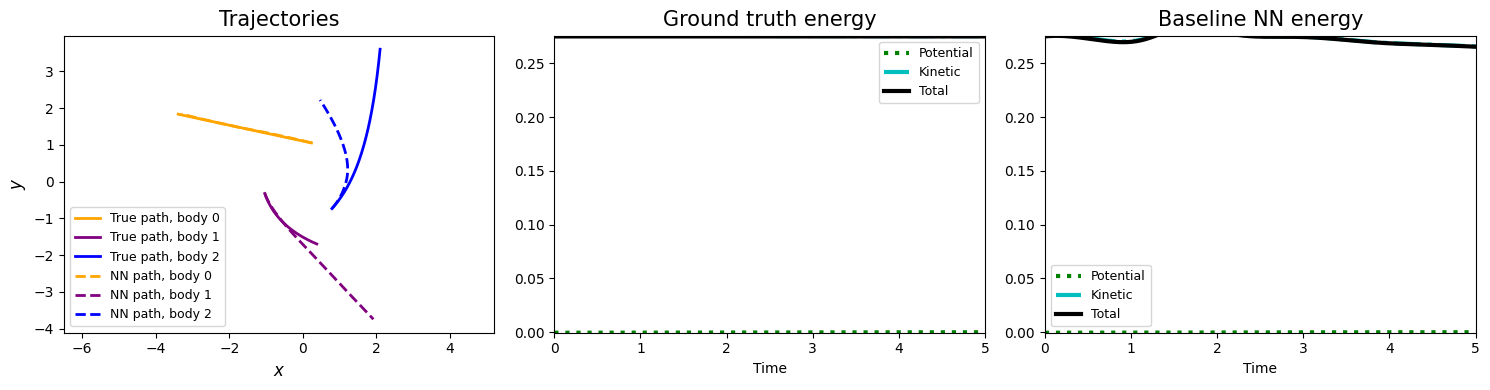

In [5]:
lw = 3  #linewidth
fs = 9
ts = 15
tpad = 7
ls = 12

hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
fig = plt.figure(figsize=[15, 4], dpi=100)
plt.subplot(1, 3, 1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple', 'blue']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)

for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls);
plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1, 3, 2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1, 3, 3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout();
plt.show()


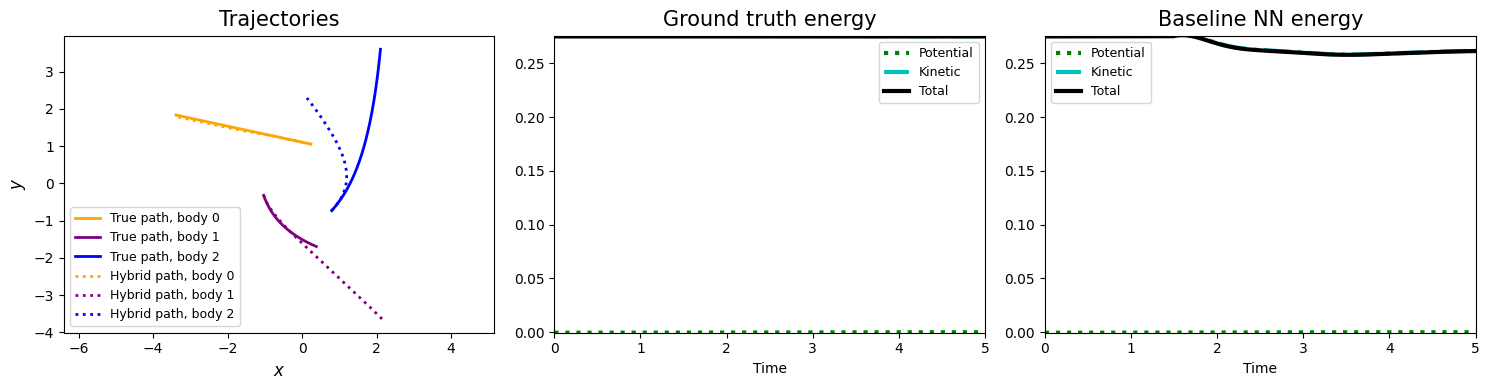

In [6]:
#hybrid use

# get predicted acceleration by the hnn model

from data import get_accelerations, update


def predicted_acceleration(state, model):
    state = state.reshape(-1, 5)

    deriv = np.zeros_like(state)
    np_x = state[:, 1:]  # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_deriv(x)
    deriv[:, 1:] = dx_hat.detach().data.numpy().reshape(4, 3).T
    deriv = deriv.reshape(-1)
    deriv = deriv.reshape((3, 5))
    return deriv


def actual_acceleration(state):
    dx_hat = update(None, state)
    dx_hat = dx_hat.reshape((3, 5))
    # only want last 2 columns of dx_hat
    return dx_hat


hybrid_orbit = np.zeros((3, 5, t_points))
prev_acc = actual_acceleration(state)
hybrid_orbit[:, :, 0] = state
for i in range(1, t_points):
    # only step forward using the get_orbit function if predicted acceleration has large diference compared to previous one
    # otherwise use the update_fun with solve_ivp to step forwards

    acceleration = None
    if np.linalg.norm(
            predicted_acceleration(hybrid_orbit[:, :, i - 1], hnn_model) - prev_acc) > 0.09:
        # hybrid_orbit[:, :, i] = \
        #     get_orbit(hybrid_orbit[:, :, i - 1], t_points=2, t_span=(0, (t_span[1] - t_span[0]) / t_points))[0][:, :, 1]
        hybrid_orbit[:, :, i] = hybrid_orbit[:, :, i - 1] + \
                                actual_acceleration(hybrid_orbit[:, :, i - 1]) * (t_span[1] - t_span[0]) / t_points
    else:
        # hybrid_orbit[:, :, i] = \
        #     get_orbit(hybrid_orbit[:, :, i - 1], t_points=2, t_span=(0, (t_span[1] - t_span[0]) / t_points),
        #               update_fn=update_fn)[0][:, :, 1]
        hybrid_orbit[:, :, i] = hybrid_orbit[:, :, i - 1] + \
                                predicted_acceleration(hybrid_orbit[:, :, i - 1], hnn_model) * (
                                        t_span[1] - t_span[0]) / t_points
    acceleration = actual_acceleration(hybrid_orbit[:, :, i])
    prev_acc = acceleration

#graph hybrid orbit
fig = plt.figure(figsize=[15, 4], dpi=100)
plt.subplot(1, 3, 1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple', 'blue']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)

for i, path in enumerate(hybrid_orbit):
    plt.plot(path[1], path[2], ':', c=colors[i], label='Hybrid path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls);
plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1, 3, 2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1, 3, 3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hybrid_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hybrid_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hybrid_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout();
plt.show()
